In [1]:
import os
from os.path import join, exists, dirname, basename
from glob import glob
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import pearsonr
from obspy.signal.trigger import classic_sta_lta

from filtering import freq_filt
from correlate import zero_lag_correlate
from attenuation import attenuation_coefficent
from conversions import dB_convert

In [3]:
local_data_dir = '/bsuhome/zacharykeskinen/scratch/data/infrasound/array_data'
with open(join(local_data_dir, 'merged/full_days'), 'rb') as f:
    days = pickle.load(f)

In [20]:
a = iter(days.values())

def process(fps):
    res = snow_attenuation(fps, 10, hs = 1.4)
    day = basename(fps[0.33]).replace('_c1.parq','')
    return res
    # with join(tmp_dir, day, 'wb') as f:
    #     pickle.dump(res, f)
process(next(a))

In [4]:
for day, fps in days.items():
    if day == '2022-02-03':
        test = fps
        for h, f in fps.items():
            if h == 2:
                arr1 = pd.read_parquet(f)['pa'].values
            if h == 0.33:
                arr2 = pd.read_parquet(f)['pa'].values
            if h == 1:
                arr3 = pd.read_parquet(f)['pa'].values
            #plt.plot(arr[::100])

In [25]:
snow_attenuation(test, 10, hs = 1.4)

/bsuhome/zacharykeskinen/infrasound/src/functions/correlate.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.einsum('i,i->',A_mA,B_mB)/np.sqrt(ssA*ssB)


{'1.33-0.33': 3.535477826528596e-05,
 '1.33-0.66': 3.272795545076107e-05,
 '1.33-1': 2.4034944734409877e-05,
 '0.33-0.66': 2.6268228145248868e-06,
 '0.33-1': 1.131983353087608e-05,
 '0.66-1': 8.693010716351193e-06}

In [24]:
def snow_attenuation(h_dic, wind_s, hs, fc_low = 1, fc_high = 20, sps = 200):
    e = False
    res = {}
    arr_d = {}
    for h, f in h_dic.items():
        if h == 2:
            arr_fa = pd.read_parquet(f)['pa'].values
            arr_fa = freq_filt(arr_fa, (fc_low, fc_high), kind = 'bandpass')
        else:
            if h < hs:
                arr_d[h] = freq_filt(pd.read_parquet(f)['pa'].values, (fc_low, fc_high), kind = 'bandpass')
                if arr_d[h].size != 17280000:
                    return None
    out = zero_lag_correlate(arr_fa, arr_d[0.33], wind_s, sps = sps)
    out[:wind_s*sps] = 0
    out[-wind_s*sps:] = 0
    # out = np.zeros_like(arr_fa)
    # out[10000:10300] = 1
    
    for (h1, arr1), (h2, arr2) in itertools.combinations(arr_d.items(), r = 2):
        signal_power_diff = signal_power_calc(arr1, arr2, abs(h1 - h2), out)
        res[f'{h1}-{h2}'] = signal_power_diff
    
    return res

In [22]:
def signal_power_calc(arr1, arr2, z, out, sps = 200, threshold = 0.8):
    idx = out>threshold
    arr1 = arr1[idx]
    l_time = arr1.size/sps
    arr1_p = np.sum((arr1**2)/sps)/(l_time)
    arr2 = arr2[idx]
    l_time = arr2.size/sps
    arr2_p = np.sum((arr2**2)/sps)/(l_time)

    return np.abs(arr1_p - arr2_p)

In [15]:
def calculate_correlated_attenuation_coef(arr1, arr2, z, out, threshold = 0.8):
    idx = out>threshold
    arr1 = np.abs(arr1[idx])
    arr2 = np.abs(arr2[idx])
    atten_arr = attenuation_coefficent(z, arr1, arr2)
    print(atten_arr)
    mean_attenuation = np.nanmean(atten_arr)
    return mean_attenuation

In [17]:
def attenuation_coefficent(z, arr1, arr2):
    return np.abs(dB_convert(arr2) - dB_convert(arr1)) / z

In [9]:
dB_convert(arr1)

array([-9.82466459, -9.82224263, -9.81256901, ..., -8.31252222,
       -8.32965716, -8.27336582])

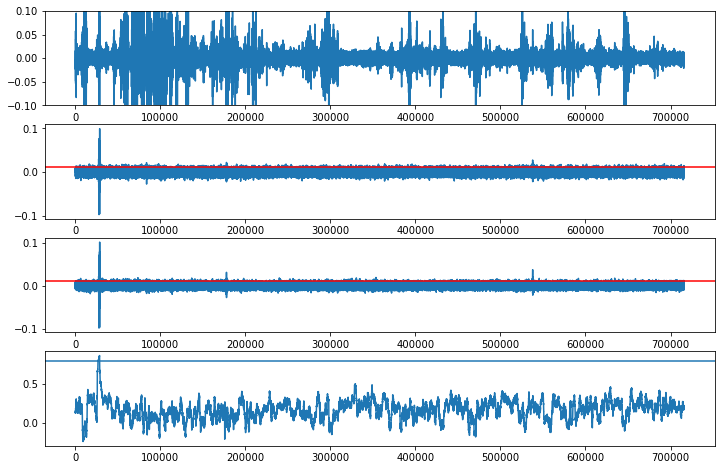

In [83]:
sps = 200
wind_s = 10
wind_n = sps*wind_s
f, (ax1,ax2,ax3, axcorr) = plt.subplots(4,1, figsize= (12,8))

n = 0
arr1f = np.split(freq_filt(arr1, (1,20), kind = 'bandpass'), 24)[n]
arr2f = np.split(freq_filt(arr2, (1,20), kind = 'bandpass'), 24)[n]
arr3f = np.split(freq_filt(arr3, (1,20), kind = 'bandpass'), 24)[n]

ax1.plot(arr1f[wind_n:-wind_n])
ax1.set_ylim((-0.1,0.1))
ax2.plot(arr2f[wind_n:-wind_n])
ax2.axhline(np.quantile(arr2f, 0.995), color = 'red')
ax3.plot(arr3f[wind_n:-wind_n])
ax3.axhline(np.quantile(arr3f, 0.995), color = 'red')
out = zero_lag_correlate(arr1f, arr2f, wind_s)

axcorr.plot(out[wind_n:-wind_n])
axcorr.axhline(0.8)

In [84]:
idx = out>0.8
c_arr2 = arr2f[idx]
c_arr3 = arr3f[idx]

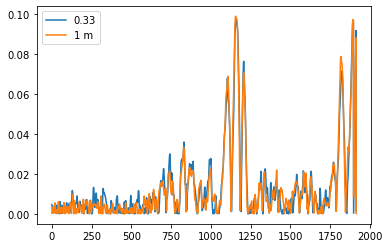

In [97]:
plt.plot(np.abs(c_arr2), label = '0.33')
plt.plot(np.abs(c_arr3), label = '1 m')
plt.legend()

In [86]:
np.abs(attenuation_coefficent(1, np.max(c_arr3), np.max(c_arr2)))

0.04049488125651168

In [98]:
np.abs(attenuation_coefficent(1, np.max(np.abs(c_arr3)), np.max(np.abs(c_arr2))))

0.016355011199119373

In [99]:
np.nanmean(attenuation_coefficent(1, np.abs(c_arr2), np.abs(c_arr3)))

0.029588221882314122

In [ ]:
np.nanmean(attenuation_coefficent(1, c_arr2, c_arr3))

In [28]:
res = {'1.33-0.33': 3.535477826528596e-05,
 '1.33-0.66': 3.272795545076107e-05,
 '1.33-1': 2.4034944734409877e-05,
 '0.33-0.66': 2.6268228145248868e-06,
 '0.33-1': 1.131983353087608e-05,
 '0.66-1': 8.693010716351193e-06}

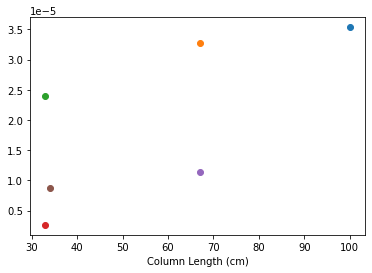

In [35]:
for hs, p_diff in res.items():
    h1, h2 = hs.split('-')
    h1, h2 = float(h1), float(h2)
    z = abs(h2-h1)*100
    plt.scatter(z, p_diff)
    plt.xlabel('Column Length (cm)')

In [31]:
h1

'0.66'